In [290]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [291]:
FINAL = '/Users/user/data/research/proton-deuteron/csv/final.pkl' # clean protons + deuterons

In [292]:
df = pd.read_pickle(FINAL)

In [293]:
df.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'beamline_mass', 'energy', 'rr'],
      dtype='object')

In [294]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

In [295]:
cols = ['run', 'subrun', 'event', 'energy', 'rr', 'beamline_mass']
df_small = df[cols]
dfs = [row.to_frame().T for _, row in df_small.iterrows()]

In [296]:
def normalize_rr(row):
    rr = np.asarray(row['rr'])
    rr_min = rr.min()
    rr_max = rr.max()
    if rr_max > rr_min:
        return (rr - rr_min) / (rr_max - rr_min)
    else:
        return np.zeros_like(rr)

df['rr_norm'] = df.apply(normalize_rr, axis=1)

In [395]:
# Add a column to df with the max value from each 'energy' array
df['energy_max'] = df['energy'].apply(lambda arr: np.max(arr) if isinstance(arr, (np.ndarray, list)) and len(arr) > 0 else np.nan)
df['energy_max'].head()

0    20719.0
1     5736.0
2    16285.0
3     5922.0
4     5006.0
Name: energy_max, dtype: float64

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.

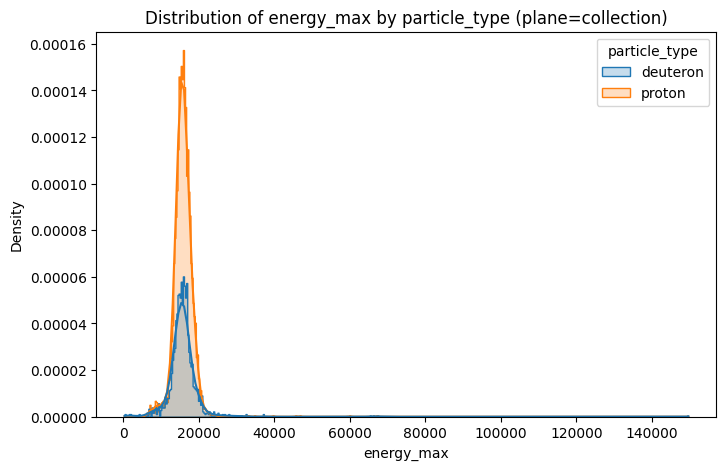

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.

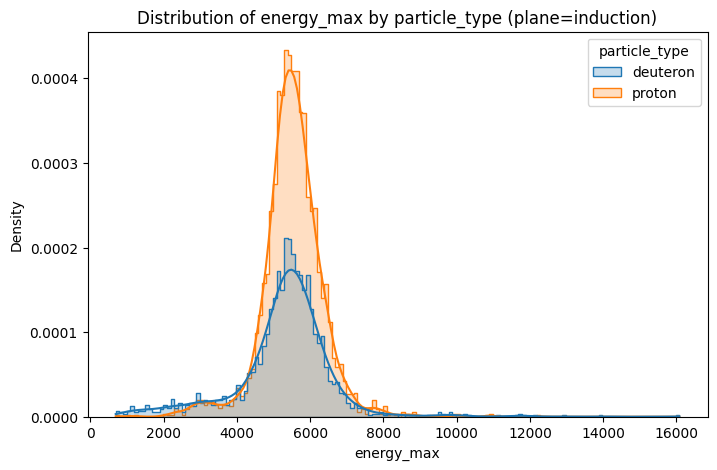

In [401]:
if 'particle_type' in df.columns and 'plane' in df.columns:
    for plane_val in df['plane'].unique():
        plt.figure(figsize=(8, 5))
        subset = df[df['plane'] == plane_val]
        sns.histplot(data=subset, x='energy_max', hue='particle_type', bins='auto', kde=True, element='step', stat='density')
        plt.title(f"Distribution of energy_max by particle_type (plane={plane_val})")
        plt.xlabel('energy_max')
        plt.ylabel('Density')
        plt.show()
else:
    print("Column 'particle_type' or 'plane' not found in df.")

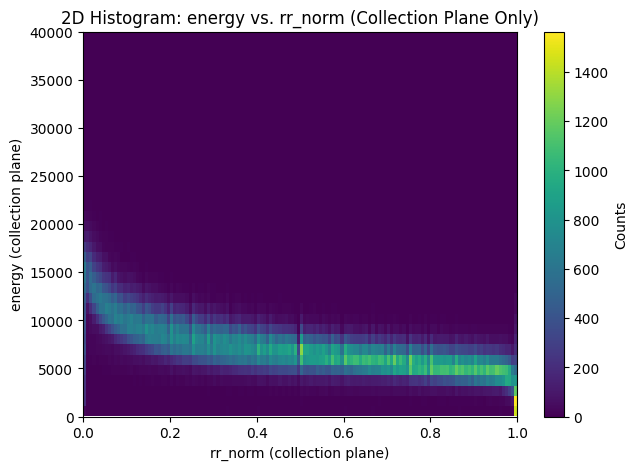

In [305]:
# 2D histogram of energy vs. rr_norm for collection plane only
collection_plane = 'collection'  # Change if your collection plane uses a different value
df_coll = df[df['plane'] == collection_plane]
plt.figure(figsize=(7, 5))
plt.hist2d(np.concatenate(df_coll['rr_norm'].values), np.concatenate(df_coll['energy'].values), bins=140, cmap='viridis')
plt.xlabel('rr_norm (collection plane)')
plt.ylabel('energy (collection plane)')
plt.title('2D Histogram: energy vs. rr_norm (Collection Plane Only)')
plt.colorbar(label='Counts')
plt.ylim(0, 40000)
plt.show()

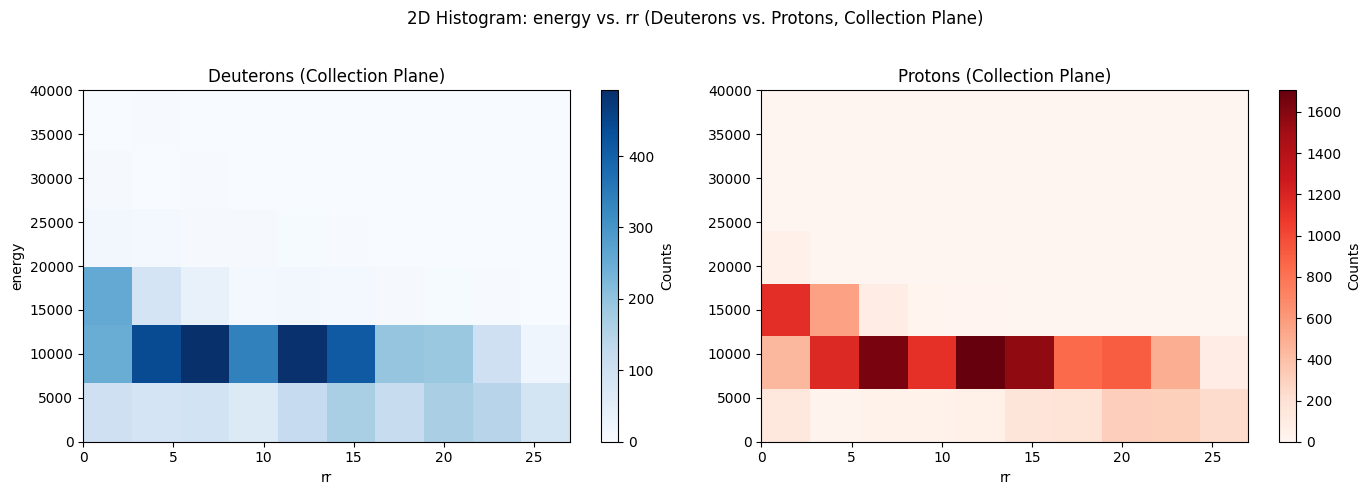

In [429]:
# 2D histograms for collection plane: deuterons vs. protons
collection_plane = 'collection'  # Change if your collection plane uses a different value
df_coll = df[df['plane'] == collection_plane]

# deuteron_mass = 1875.6  # MeV/c^2
# proton_mass = 938.3     # MeV/c^2
# mass_tol = 100           # MeV/c^2

# df_deut = df_coll[(np.abs(df_coll['beamline_mass'] - deuteron_mass) < mass_tol) & (df_coll['height'] < 30)]
# df_prot = df_coll[np.abs(df_coll['beamline_mass'] - proton_mass) < mass_tol]

df_deut = df_coll[(df_coll['particle_type'] == 'deuteron') & (df_coll['height'] < 30)]
df_prot = df_coll[(df_coll['particle_type'] == 'proton') & (df_coll['height'] < 30)]


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

h1 = axes[0].hist2d(np.concatenate(df_deut['rr'].values), np.concatenate(df_deut['energy'].values), bins=10, cmap='Blues')
axes[0].set_title('Deuterons (Collection Plane)')
axes[0].set_xlabel('rr')
axes[0].set_ylabel('energy')
axes[0].set_ylim(0, 40000)
fig.colorbar(h1[3], ax=axes[0], label='Counts')

h2 = axes[1].hist2d(np.concatenate(df_prot['rr'].values), np.concatenate(df_prot['energy'].values), bins=10, cmap='Reds')
axes[1].set_title('Protons (Collection Plane)')
axes[1].set_xlabel('rr')
axes[1].set_ylim(0, 40000)
fig.colorbar(h2[3], ax=axes[1], label='Counts')

plt.suptitle('2D Histogram: energy vs. rr (Deuterons vs. Protons, Collection Plane)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [435]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, DotProduct, RationalQuadratic, Matern
import numpy as np

def fit_gp_energy_vs_rr(row):
    rr = np.asarray(row['rr'])
    energy = np.asarray(row['energy'])
    if rr.size > 1 and energy.size > 1:
        X = rr.reshape(-1, 1)      # independent variable
        y = energy                 # dependent variable

        kernel = (DotProduct() + ConstantKernel(1.0, (1e-3, 1e3)) *
                  RBF(length_scale=(1 // 5), length_scale_bounds=(0.01, 240.0)) +
                  WhiteKernel(noise_level=5.0, noise_level_bounds=(1e-1, 1e3)))
        
        # a, b = max(energy), len(rr)        # your nominal estimates

        # kernel = ConstantKernel(a**2, (1e-3, 1e3)) * \
        #         RBF(length_scale=b/5,  # controls decay rate
        #             length_scale_bounds=(1.0, b)) + \
        #         WhiteKernel(noise_level=10.0, noise_level_bounds=(1e-2, 1e2))
    
        gp = GaussianProcessRegressor(
            kernel=kernel,
            optimizer="fmin_l_bfgs_b",
            n_restarts_optimizer=5,
            normalize_y=True
        )
        gp.fit(X, y)
        return gp
    else:
        return None

# Example: fit GP to the first row
# gp_model = fit_gp_energy_vs_rr(df_small.iloc[0])
df_prot_s = df_prot.sample(n=250)
# To fit for all rows and store the models:
dgp_models = [fit_gp_energy_vs_rr(row) for _, row in df_deut.iterrows()]
pgp_models = [fit_gp_energy_vs_rr(row) for _, row in df_prot_s.sample(n=250).iterrows()]

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. D

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


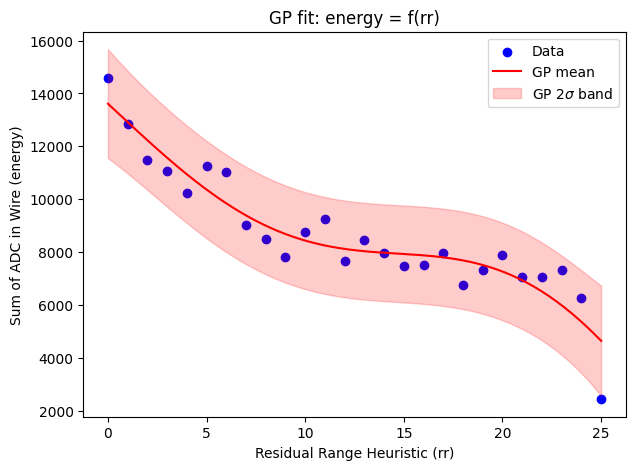

In [436]:
import matplotlib.pyplot as plt
import numpy as np

# Fit GP to a single row
row = df_deut.iloc[2]
gp = fit_gp_energy_vs_rr(row)

rr = np.asarray(row['rr']) 
energy = np.asarray(row['energy'])

# Create a smooth range for prediction
rr_pred = np.linspace(rr.min(), rr.max(), 200).reshape(-1, 1)
energy_pred, sigma = gp.predict(rr_pred, return_std=True)

plt.figure(figsize=(7, 5))
plt.scatter(rr, energy, label='Data', color='blue')
plt.plot(rr_pred, energy_pred, color='red', label='GP mean')
plt.fill_between(rr_pred.flatten(),
                 energy_pred - 2*sigma,
                 energy_pred + 2*sigma,
                 color='red', alpha=0.2, label='GP 2$\sigma$ band')
plt.xlabel('Residual Range Heuristic (rr)')
plt.ylabel('Sum of ADC in Wire (energy)')
plt.title('GP fit: energy = f(rr)')
plt.legend()
plt.show()

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/u

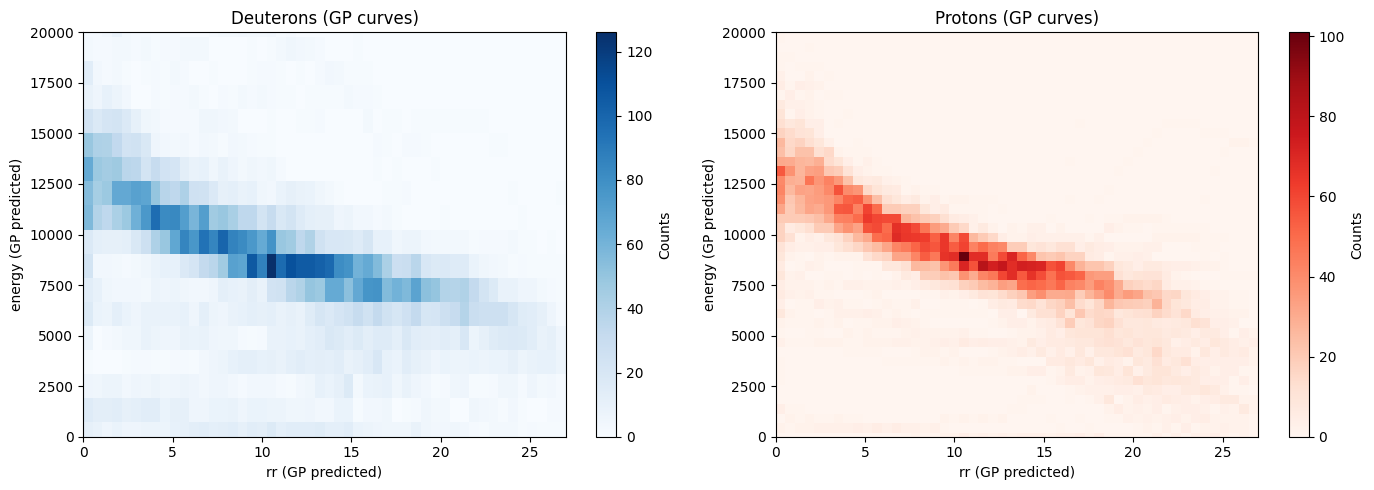

In [437]:
import numpy as np
import matplotlib.pyplot as plt

def gp_hist2d(df, gp_models, bins=50, cmap='Reds', title=''):
    rr_pred_all = []
    energy_pred_all = []
    for row, gp in zip(df.itertuples(), gp_models):
        if gp is not None:
            rr = np.asarray(row.rr)
            rr_pred = np.linspace(rr.min(), rr.max(), 50).reshape(-1, 1)
            energy_pred = gp.predict(rr_pred)
            rr_pred_all.append(rr_pred.flatten())
            energy_pred_all.append(energy_pred)
    rr_pred_all = np.concatenate(rr_pred_all)
    energy_pred_all = np.concatenate(energy_pred_all)
    plt.hist2d(rr_pred_all, energy_pred_all, bins=bins, cmap=cmap)
    plt.xlabel('rr (GP predicted)')
    plt.ylabel('energy (GP predicted)')
    plt.title(title)
    plt.ylim(0, 20000)
    plt.colorbar(label='Counts')

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
gp_hist2d(df_deut, dgp_models, bins=50, cmap='Blues', title='Deuterons (GP curves)')

plt.subplot(1, 2, 2)
gp_hist2d(df_prot_s, pgp_models, bins=50, cmap='Reds', title='Protons (GP curves)')

plt.tight_layout()
plt.show()

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/u

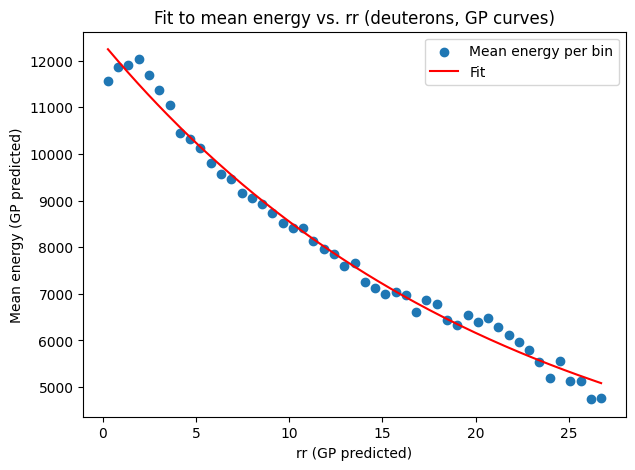

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/u

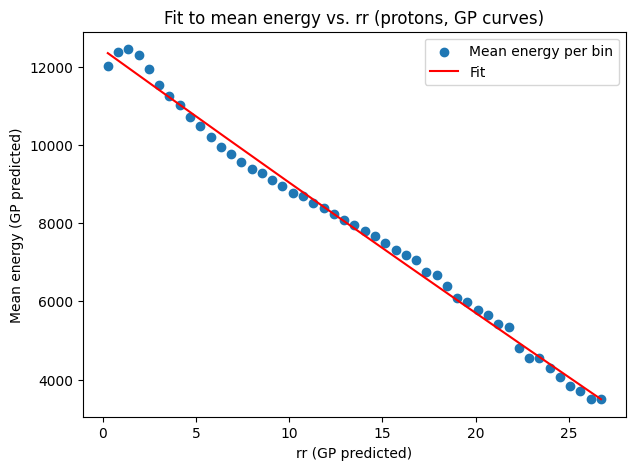

In [439]:
# Fit a curve to the GP-predicted 2D histogram for deuterons
from scipy.optimize import curve_fit
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Deuterons
rr_all_deut = np.concatenate([np.linspace(np.asarray(row.rr).min(), np.asarray(row.rr).max(), 50) for row, gp in zip(df_deut.itertuples(), dgp_models) if gp is not None])
energy_all_deut = np.concatenate([gp.predict(np.linspace(np.asarray(row.rr).min(), np.asarray(row.rr).max(), 50).reshape(-1, 1)) for row, gp in zip(df_deut.itertuples(), dgp_models) if gp is not None])
bins_deut = np.linspace(rr_all_deut.min(), rr_all_deut.max(), 50)
digitized_deut = np.digitize(rr_all_deut, bins_deut)
bin_centers_deut = 0.5 * (bins_deut[1:] + bins_deut[:-1])
mean_energy_deut = [energy_all_deut[digitized_deut == i].mean() if np.any(digitized_deut == i) else np.nan for i in range(1, len(bins_deut))]
mask_deut = ~np.isnan(mean_energy_deut)

# Provide a better initial guess and increase maxfev
masked_mean_energy_deut = np.array(mean_energy_deut)[mask_deut]
p0_deut = [masked_mean_energy_deut.max() - masked_mean_energy_deut.min(), 0.1, masked_mean_energy_deut.min()]
popt_deut, _ = curve_fit(exp_func, bin_centers_deut[mask_deut], masked_mean_energy_deut, p0=p0_deut, maxfev=5000)

plt.figure(figsize=(7,5))
plt.scatter(bin_centers_deut, mean_energy_deut, label='Mean energy per bin')
x_fit = np.linspace(bin_centers_deut[mask_deut].min(), bin_centers_deut[mask_deut].max(), 200)
plt.plot(x_fit, exp_func(x_fit, *popt_deut), 'r-', label='Fit')
plt.xlabel('rr (GP predicted)')
plt.ylabel('Mean energy (GP predicted)')
plt.title('Fit to mean energy vs. rr (deuterons, GP curves)')
plt.legend()
plt.show()

# Protons
rr_all_prot = np.concatenate([np.linspace(np.asarray(row.rr).min(), np.asarray(row.rr).max(), 50) for row, gp in zip(df_prot_s.itertuples(), pgp_models) if gp is not None])
energy_all_prot = np.concatenate([gp.predict(np.linspace(np.asarray(row.rr).min(), np.asarray(row.rr).max(), 50).reshape(-1, 1)) for row, gp in zip(df_prot_s.itertuples(), pgp_models) if gp is not None])
bins_prot = np.linspace(rr_all_prot.min(), rr_all_prot.max(), 50)
digitized_prot = np.digitize(rr_all_prot, bins_prot)
bin_centers_prot = 0.5 * (bins_prot[1:] + bins_prot[:-1])
mean_energy_prot = [energy_all_prot[digitized_prot == i].mean() if np.any(digitized_prot == i) else np.nan for i in range(1, len(bins_prot))]
mask_prot = ~np.isnan(mean_energy_prot)

# Provide a better initial guess and increase maxfev
masked_mean_energy_prot = np.array(mean_energy_prot)[mask_prot]
p0_prot = [masked_mean_energy_prot.max() - masked_mean_energy_prot.min(), 0.1, masked_mean_energy_prot.min()]
popt_prot, _ = curve_fit(exp_func, bin_centers_prot[mask_prot], masked_mean_energy_prot, p0=p0_prot, maxfev=5000)

plt.figure(figsize=(7,5))
plt.scatter(bin_centers_prot, mean_energy_prot, label='Mean energy per bin')
x_fit = np.linspace(bin_centers_prot[mask_prot].min(), bin_centers_prot[mask_prot].max(), 200)
plt.plot(x_fit, exp_func(x_fit, *popt_prot), 'r-', label='Fit')
plt.xlabel('rr (GP predicted)')
plt.ylabel('Mean energy (GP predicted)')
plt.title('Fit to mean energy vs. rr (protons, GP curves)')
plt.legend()
plt.show()


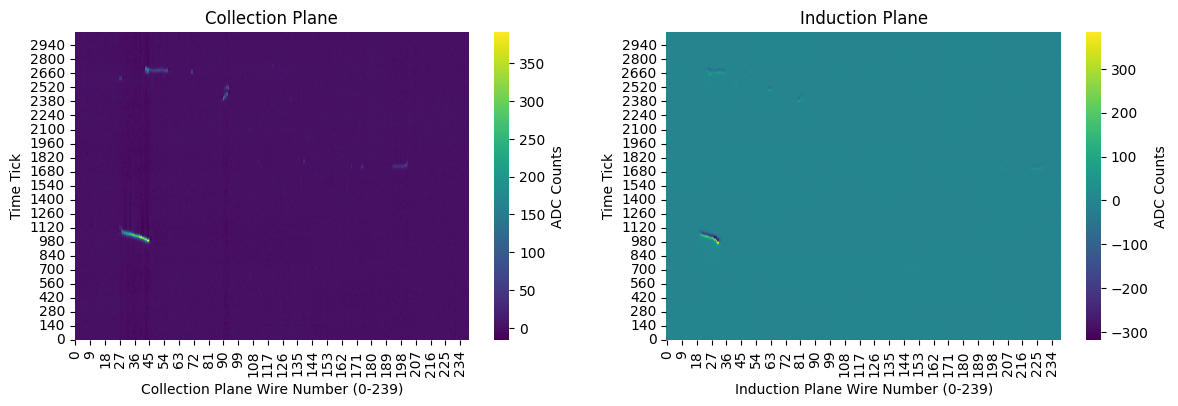

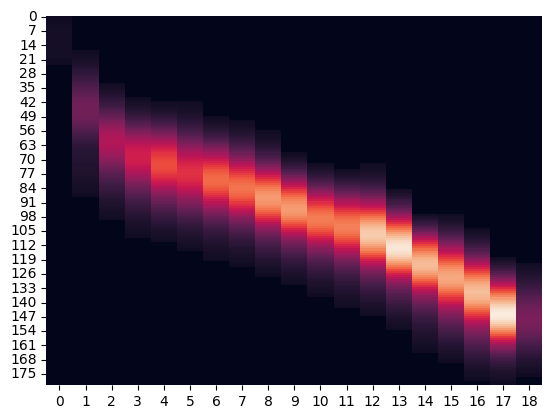

In [428]:
sample = df_deut.sample(n=1)
filepath = sample['file_path'].iloc[0]
index = sample['event_index'].iloc[0]

event = Event(filepath, index)
sns.heatmap(sample['matrix_transformed'].iloc[0], cbar=False)
plt.show()